# Resource-Constrained Project Scheduling with Time-Offs

This notebook addresses RCPSP variants where resources have individual availability calendars. It explores five problems that differ in how tasks handle interruptions and resource reassignments. Each resource unit of each resource type has its own availability calendar (available/unavailable periods). Preemption is possible either by changing resource units of the same resource type during execution (if migration is allowed) or by pausing the task execution according to its calendar (and after the pause continuing on the same resource unit).

1. **[Non-Preemptive | No Migration](#1-non-preemptive--no-migration)**: Tasks execute continuously without interruption, resources must be available throughout entire task duration
2. **[Preemptive (No Delays) | Migration](#2-preemptive-no-delays--migration)**: Tasks pause and immediately switch to available alternative resources
3. **[Preemptive (With Delays) | No Migration](#3-preemptive-with-delays--no-migration)**: Tasks pause when resources are unavailable, resume later on the same resources; resources remain blocked during pauses
4. **[Preemptive (With Delays) | Migration](#4-preemptive-with-delays--migration)**: Combines pausing with the ability to switch resource units
5. **[Multi-Resource Heterogeneous Policy](#5-multi-resource-heterogeneous-policy)**: Different resource types follow different policies. workers allow migration while machines do not


### Data Import & Parsing

In [1]:
import docplex.cp.utils_visu as visu
import matplotlib as plt
from itertools import combinations, product
from docplex.cp.model import CpoStepFunction

In [2]:
def next_line(f):
    """Read next non-empty, non-comment line."""
    line = None
    while not line:
        raw = f.readline()
        if not raw:
            return None
        line = raw.strip()
        if line.startswith('#'):
            line = None
    return [int(v) for v in line.split()]

In [3]:
def load_instance(filename):
    """Load RCPSP with time-offs instance from file.
    Returns: (N, M, TASKS, RESOURCES, PRECEDENCES) where
        - N: number of tasks
        - M: number of resources
        - TASKS: [(task_id, size, [(qty, [candidate_ids]), ...]), ...]
        - RESOURCES: [(res_id, [(time, intensity), ...]), ...]
        - PRECEDENCES: [(pred_task, succ_task), ...]
    """
    with open(filename, "r") as f:
        N, M = next_line(f)
        TASKS = []
        for _ in range(N):
            d = next_line(f)
            reqs, idx = [], 3
            for _ in range(d[2]):
                reqs.append((d[idx+1], d[idx+2:idx+2+d[idx]]))
                idx += 2 + d[idx]
            TASKS.append((d[0], d[1], reqs))
        RESOURCES = [(d[0], [(d[2+2*i], d[3+2*i]) for i in range(d[1])]) 
                     for d in (next_line(f) for _ in range(M))]
        p = next_line(f)
        PRECEDENCES = [(p[1+2*i], p[2+2*i]) for i in range(p[0])]
    return N, M, TASKS, RESOURCES, PRECEDENCES

### Helper Functions and Data Structures

In [4]:
HORIZON = 100000

def build_res_map(RESOURCES):
    """Build resource availability map: res_id -> [(time, intensity), ...]"""
    return {res_id: steps for res_id, steps in RESOURCES}

def create_availability_function(steps):
    """Create CpoStepFunction for resource availability (used with forbid_extent)."""
    f = CpoStepFunction()
    for i in range(len(steps) - 1):
        f.set_value(steps[i][0], steps[i + 1][0], steps[i][1])
    if steps:
        f.set_value(steps[-1][0], HORIZON, steps[-1][1])
    return f

def build_task_modes(TASKS):
    """Generate all valid mode combinations for each task.
    Returns: {task_id: [mode_tuple, ...], ...} where mode_tuple = (res_id, ...)
    """
    return {
        task_id: [tuple(sorted({r for grp in combo for r in grp})) 
                  for combo in product(*[combinations(cands, qty) for qty, cands in reqs])] 
                 or ([()] if size == 0 else [])
        for task_id, size, reqs in TASKS
    }


def get_res_availability(res_id, time, res_map):
    """Returns availability (0 or 100) of a resource at a specific time."""
    return next((v for t, v in reversed(res_map[res_id]) if time >= t), 0)


def compute_joint_intensity(resource_ids, res_map):
    """Create CpoStepFunction for joint availability (min across all resources).
    Value is 100 only if ALL resources are available at that time.
    """
    if not resource_ids:
        return CpoStepFunction(steps=[(0, 100)])
    time_points = sorted({0} | {t for rid in resource_ids for t, _ in res_map[rid]})
    joint_steps = [(t, 100 if all(get_res_availability(rid, t, res_map) for rid in resource_ids) else 0) 
                   for t in time_points]
    f = CpoStepFunction()
    for i, (t, v) in enumerate(joint_steps[:-1]):
        f.set_value(t, joint_steps[i+1][0], v)
    if joint_steps:
        f.set_value(joint_steps[-1][0], HORIZON, joint_steps[-1][1])
    return f


def compute_all_joint_intensities(Task_Modes, RES_MAP):
    """Compute joint intensity functions for all task-mode combinations.
    Returns: {(task_id, mode_tuple): CpoStepFunction, ...}
    """
    return {
        (task_id, mode): compute_joint_intensity(mode, RES_MAP)
        for task_id, modes in Task_Modes.items()
        for mode in modes
    }

def extract_mode_intervals(sol, Unit_Intervals, T):
    """Extract Mode_Intervals from solved Unit_Intervals for visualization."""
    Mode_Intervals = {}
    for tid in T:
        selected = tuple(sorted([
            r for (t, r), itv in Unit_Intervals.items() 
            if t == tid 
            and (s := sol.get_var_solution(itv)) is not None 
            and s.is_present()
        ]))
        if selected:
            first_unit = selected[0]
            Mode_Intervals[(tid, selected)] = Unit_Intervals[(tid, first_unit)]
    return Mode_Intervals

### Visualisation

In [5]:
def print_instance(N, M, TASKS, RESOURCES, PRECEDENCES):
    print(f"\n{'='*75}")
    print(f"INSTANCE: {N} Tasks × {M} Resources")
    print(f"{'='*75}")
    res_types = {}
    for tid, size, reqs in TASKS:
        for qty, cands in reqs:
            key = tuple(sorted(cands))
            if key not in res_types:
                res_types[key] = f"T{len(res_types)+1}"
    if res_types:
        print("Types:", ", ".join([f"{t}={{R{',R'.join(map(str,r))}}}" 
                                    for r, t in res_types.items()]))
    print(f"\n{'Task':<4} {'Dur':<3} {'Requirements':<25} {'→ Succ'}")
    print(f"{'-'*75}")
    for tid, size, reqs in TASKS:
        succs = [s for p, s in PRECEDENCES if p == tid]
        if not reqs or all(q == 0 for q, _ in reqs):
            req_str = "—"
        else:
            req_str = ", ".join([f"{q}×{res_types[tuple(sorted(c))]}" 
                                 for q, c in reqs])
        print(f"T{tid:<3} {size:<3} {req_str:<25} {succs if succs else '—'}")
    print(f"\n{'Res':<4} {'Cap':<4} {'Available Windows'}")
    print(f"{'-'*75}")
    for res_id, steps in RESOURCES:
        windows = []
        for i in range(len(steps)):
            if steps[i][1] > 0:
                end = steps[i+1][0] if i+1 < len(steps) else "∞"
                windows.append(f"[{steps[i][0]}-{end})")
        cap = steps[0][1] if steps else 0
        print(f"R{res_id:<3} {cap:<4} {' '.join(windows) if windows else '—'}")
    print(f"{'='*75}\n")

In [6]:
def print_solution(sol, T, Mode_Intervals, N):
    print(f"\n{'='*75}")
    print(f"✓ SOLUTION - Makespan: {sol.get_objective_values()[0]}")
    print(f"{'='*75}")
    print(f"{'Task':<5} {'Start':<5} {'End':<5} {'Dur':<4} {'Resources'}")
    print(f"{'-'*75}")
    schedule = []
    for i in range(N):
        sol_t = sol.get_var_solution(T[i])
        if sol_t:
            start, end = sol_t.get_start(), sol_t.get_end()
            selected = next((m for (tid, m), itv in Mode_Intervals.items() 
                           if tid == i and (itv_sol := sol.get_var_solution(itv)) is not None and itv_sol.is_present()), None)
            res_str = "{R" + ",R".join(map(str, selected)) + "}" if selected and selected != () else "—"
            schedule.append((i, start, end, end-start, res_str))
    for tid, start, end, dur, res in sorted(schedule, key=lambda x: (x[1], x[0])):
        print(f"T{tid:<4} {start:<5} {end:<5} {dur:<4} {res}")
    print(f"{'='*75}\n")

In [7]:
def visualize_solution(sol, Mode_Intervals, RES_MAP, TASKS, M, 
                       figsize=(12, 4), 
                       origin=0,
                       horizon=None):
    plt.rcParams["figure.figsize"] = figsize
    task_colors = ['steelblue', 'coral', 'gold', 'mediumpurple', 'darkcyan', 'sandybrown']
    Task_Reqs_Map = {
        tid: " | ".join([f"from {{{','.join([f'R{c}' for c in cads])}}}" for qty, cads in reqs])
        for tid, size, reqs in TASKS
    }
    if horizon is None:
        horizon = max(t for steps in RES_MAP.values() for t, _ in steps)
    visu.timeline(origin=origin, horizon=horizon)
    visu.panel('Calendars')
    for r in range(M):
        visu.sequence(name=f'R{r}')
        if r in RES_MAP:
            steps = RES_MAP[r]
            for i, (t, v) in enumerate(steps):
                if i + 1 < len(steps):
                    next_t = steps[i + 1][0]
                else:
                    next_t = horizon + 1
                if v > 0:
                    visu.interval(t, next_t, 'lightgreen')
    visu.panel('Assignments')
    for r in range(M):
        visu.sequence(name=f'R{r}')
        for (tid, m_res), itv in Mode_Intervals.items():
            if r in m_res:
                sol_itv = sol.get_var_solution(itv)
                if sol_itv and sol_itv.is_present():
                    col = task_colors[tid % len(task_colors)]
                    selected = "{" + ",".join([f"R{rid}" for rid in m_res]) + "}"
                    label = f"T{tid}[{sol_itv.get_size()}]: {selected}"
                    visu.interval(sol_itv, col, label)
    visu.show()

## 1. Non-Preemptive | No Migration

Tasks must execute continuously without any interruption. Each task is assigned to exactly one mode (resource combination), and all resources in the selected mode must be continuously available throughout the entire task execution. No calendar-based pausing is allowed - if resources have time-offs, the task must be scheduled entirely within availability windows.

$$
\begin{aligned}
\min \quad
& \max_{i \in \mathcal{N}} (\operatorname{end}(T_i))
& & \text{(1)} \\[2mm]
\text{s.t.} \quad
& \operatorname{endBeforeStart}(T_i, T_j),
& \forall (i, j) \in \mathcal{E}
& \text{(2)} \\[2mm]
& \operatorname{alternative}(T_i, \{O_{i,r} \mid r \in \mathcal{U}_k\}, q_{i,k}),
& \forall i \in \mathcal{N}, \forall k \in \mathcal{K}_i
& \text{(3)} \\[2mm]
& \operatorname{noOverlap}(\{O_{i,r} \mid i \in \mathcal{N}, r \in \mathcal{C}_i\}),
& \forall r \in \mathcal{R}
& \text{(4)} \\[2mm]
& \operatorname{forbidExtent}(O_{i,r}, \overline{\mathcal{F}_r}),
& \forall i \in \mathcal{N}, \forall r \in \mathcal{C}_i
& \text{(5)} \\[2mm]
& T_i: \text{mandatory interval var with size } d_i
& \forall i \in \mathcal{N}
& \text{(6a)} \\[1mm]
& O_{i,r}: \text{optional interval var with size } d_i
& \forall i \in \mathcal{N}, \forall r \in \mathcal{C}_i
& \text{(6b)}
\end{aligned}
$$

**Sets & Parameters**
- $\mathcal{K}_i$: resource types required by task $i$ (indexed by requirement position)
- $\mathcal{U}_k$: candidate resource units for type $k$
- $q_{i,k}$: quantity of resource type $k$ required by task $i$
- $\mathcal{C}_i = \bigcup_{k \in \mathcal{K}_i} \mathcal{U}_k$: all candidate units for task $i$
- $\mathcal{F}_r$: availability calendar for unit $r$

**Objective**
- **(1)** Minimize Makespan: Minimize the project completion time.

**Modeling Constraints**
- **(2)** Precedence Relations: Standard finish-to-start dependencies.
- **(3)** Resource Type Selection: For each resource type requirement, select exactly $q_{i,k}$ units. The `alternative` with cardinality ensures all selected intervals share the same start/end as $T_i$.
- **(4)** Resource Capacity: Each resource unit can be used by at most one task at a time.
- **(5)** Calendar Compliance: Each unit interval must fall within the unit's availability windows.

**Variable Definitions**
- **(6a)** $T_i$: Master interval with fixed size $d_i$.
- **(6b)** $O_{i,r}$: Optional unit interval for task $i$ on resource unit $r$.

### DOCPLEX Implementation

#### Load Instance

In [8]:
from docplex.cp.model import *

In [9]:
N, M, TASKS, RESOURCES, PRECEDENCES = load_instance("../data/rcpspblocking/00.data")
RES_MAP = build_res_map(RESOURCES)

# F_r: Individual availability step function for each resource unit
Res_Availability = {res_id: create_availability_function(steps) 
                    for res_id, steps in RESOURCES}

#### Create model and variables

In [10]:
mdl = CpoModel(name="rcpsp_nonpreemptive_nomigration_decomposed")

# (6a) T_i: mandatory interval var with fixed size d_i
T = {tid: interval_var(size=size, name=f"T{tid}") for tid, size, _ in TASKS}

# (6b) O_{i,r}: optional interval var for each task-unit pair
# Only create intervals for units that are candidates for the task
Unit_Intervals = {}
for tid, size, reqs in TASKS:
    for qty, candidates in reqs:
        for r in candidates:
            if (tid, r) not in Unit_Intervals:
                Unit_Intervals[(tid, r)] = interval_var(
                    size=size, optional=True, name=f"T{tid}_R{r}"
                )

#### Add constraints and objective

In [11]:
# (1) objective: minimize makespan
mdl.add(minimize(max([end_of(T[tid]) for tid in T])))

# (2) precedences
mdl.add([end_before_start(T[p], T[s]) for p, s in PRECEDENCES])

# (3) alternative with cardinality: select q_k units from each resource type
for tid, size, reqs in TASKS:
    for qty, candidates in reqs:
        if qty > 0 and candidates:
            unit_intervals = [Unit_Intervals[(tid, r)] for r in candidates]
            mdl.add(alternative(T[tid], unit_intervals, cardinality=qty))

# (4) resource capacity: noOverlap per resource unit
for r in range(M):
    intervals = [itv for (tid, rid), itv in Unit_Intervals.items() if rid == r]
    if intervals:
        mdl.add(no_overlap(intervals))

# (5) calendar compliance: forbidExtent for each unit interval
for (tid, r), itv in Unit_Intervals.items():
    if r in Res_Availability:
        mdl.add(forbid_extent(itv, Res_Availability[r]))

In [12]:
print("Solving Non-Preemptive | No Migration (Decomposed)...")
sol = mdl.solve(LogVerbosity='Quiet')

Solving Non-Preemptive | No Migration (Decomposed)...


In [13]:
Mode_Intervals = extract_mode_intervals(sol, Unit_Intervals, T)
print_solution(sol, T, Mode_Intervals, N)


✓ SOLUTION - Makespan: 10
Task  Start End   Dur  Resources
---------------------------------------------------------------------------
T0    0     0     0    —
T1    4     8     4    {R0}
T2    8     10    2    {R0,R1}
T3    10    10    0    —



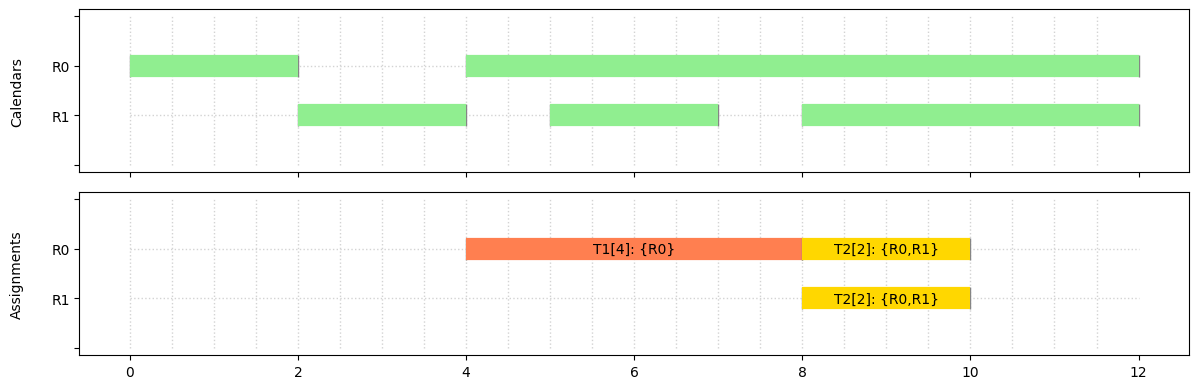

In [14]:
visualize_solution(sol, Mode_Intervals, RES_MAP, TASKS, M, origin=0, horizon=12)

## 2. Preemptive (No Delays) | Migration

## 3. Preemptive (With Delays) | No Migration

### Problem Definiton

We consider a project scheduling problem with a set of tasks $\mathcal{N}$ having fixed processing durations and subject to finish-to-start precedence relations $\mathcal{E}$.
Each task $i$ defines its requirements in terms of specific quantities of various resource types. For example, a task might require "2 Electricians and 1 Plumber". To fulfill these requirements, the task must be assigned to exactly one feasible team composition, known as a mode ($m \in \mathcal{M}_i$). Each mode $m$ specifies a concrete set of resource units $\mathcal{R}_{i,m}$ that satisfy the task's resource type requirements. Continuing the example, a specific mode might assign the resource unit "John" (who belongs to resource type "Electrician"), the resource unit "Mary" (who also belongs to resource type "Electrician"), and the resource unit "Steve" (who belongs to resource type "Plumber"). Each resource unit $r$ operates according to its own availability calendar $\mathcal{F}_r(t) \in \{0, 1\}$. The key challenge is synchronous blocking with calendar-based preemption. When a task requires multiple resource units, all assigned units must be available simultaneously. If resource unit John has a calendar-based day off, the task progress pauses, and resource units Mary and Steve remain blocked and unavailable to other tasks, even if their own calendars show they are available. Furthermore, resource capacity constraints ensure each unit can be assigned to at most one task at any time.

### CP Optimizer Formulation

$$
\begin{aligned}
\min \quad
& \max_{i \in \mathcal{N}} (\operatorname{end}(T_i))
\qquad &\qquad & \text{(1)} \\[2mm]
\text{s.t.} \quad
& \operatorname{endBeforeStart}(T_i, T_j),
\qquad & \forall (i, j) \in \mathcal{E}
\quad & \text{(2)} \\[2mm]
& \operatorname{alternative}(T_i, \{O_{i,m} \mid m \in \mathcal{M}_i\}),
\qquad & \forall i \in \mathcal{N}
\quad & \text{(3)} \\[2mm]
& \operatorname{noOverlap}(\{O_{i,m} \mid i \in \mathcal{N}, m \in \mathcal{M}_i, r \in \mathcal{R}_{i,m}\}),
\qquad & \forall r \in \mathcal{R}
\quad & \text{(4)} \\[2mm]
& \operatorname{sizeOf}(O_{i,m}) = \int_{\operatorname{start}(O_{i,m})}^{\operatorname{end}(O_{i,m})} \mathcal{G}_{i,m}(t) \, dt,
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(5)} \\[2mm]
& \mathcal{G}_{i,m}(t) = \min_{r \in \mathcal{R}_{i,m}} (\mathcal{F}_r(t)),
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(6)} \\[2mm]
& T_i: \text{mandatory interval var }
\qquad & \forall i \in \mathcal{N}
\quad & \text{(7a)} \\[1mm]
& O_{i,m}: \text{optional interval var}, \text{ intensity } \mathcal{G}_{i,m},
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(7b)}
\end{aligned}
$$

Objective

* **(1)** Minimize Makespan: Minimize the project completion time (the end time of the last task).

Modeling Constraints

* **(2)** Precedence Relations: Standard finish-to-start dependencies between tasks.
* **(3)** Mode Selection & Synchronization: The alternative constraint forces the solver to select exactly one valid combination of resource units (Mode $m$) for task $i$. It strictly synchronizes the Master Task $T_i$ with the selected Mode Interval $O_{i,m}$.
* **(4)** Resource Capacity: Ensures that an individual resource unit $r$ is processing by at most one task at a time. This constraint iterates over all potential modes $m$ across all tasks that contain the specific resource unit $r$.
* **(5)** Calendar-Based Blocking: The size (work content) of the mode interval is determined by the joint intensity $\mathcal{G}_{i,m}$. If the joint intensity is 0 (meaning any assigned resource unit, e.g., John, is on a break), the integral pauses the accumulation of size, forcing the interval duration to elongate. Because the resource units remain strictly assigned to this interval, Mary and Steve remain "Blocked" (unavailable to other tasks) during John's break.

Variable and Function Definitions

* **(6)** $\mathcal{G}_{i,m}(t)$: The joint intensity function. It represents the intersection of availability calendars. It is $100\%$ only if all resource units in mode $m$ are available at time $t$. If even one resource unit is unavailable, the value drops to 0.
* **(7a)** $T_i$: The Master interval variable representing the task execution window.
* **(7b)** $O_{i,m}$: An optional interval variable representing a specific assignment of resource units (Mode). Its intensity is linked to $\mathcal{G}_{i,m}$.

Parameters (Input Data)

* $\mathcal{N}$: The set of tasks.
* $\mathcal{M}_i$: The set of valid Modes for task $i$. These are pre-calculated combinations of resource units that satisfy the quantity requirements defined by the resource types.
* $\mathcal{R}_{i,m}$: The specific set of resource unit IDs belonging to mode $m$ of task $i$.
* $\mathcal{F}_r(t)$: The individual availability step function for the specific resource unit $r$.

### DOCPLEX Implementation

#### Load Instance

In [15]:
from docplex.cp.model import CpoModel, CpoStepFunction, interval_var, end_of, end_before_start, alternative, no_overlap, minimize

In [16]:
N, M, TASKS, RESOURCES, PRECEDENCES = load_instance("../data/rcpspblocking/00.data")
RES_MAP = build_res_map(RESOURCES)
Task_Modes = build_task_modes(TASKS)
print_instance(N, M, TASKS, RESOURCES, PRECEDENCES)


INSTANCE: 4 Tasks × 2 Resources
Types: T1={R0,R1}

Task Dur Requirements              → Succ
---------------------------------------------------------------------------
T0   0   —                         [1, 2]
T1   4   1×T1                      [3]
T2   2   2×T1                      [3]
T3   0   —                         —

Res  Cap  Available Windows
---------------------------------------------------------------------------
R0   100  [0-2) [4-12)
R1   0    [2-4) [5-7) [8-12)



#### Create model and variables

In [17]:
mdl = CpoModel(name="preemptive_delays_nomigration_cpo")

In [18]:
# (6) G_{i,m}(t) = min(F_r(t)) - Joint intensity functions
Joint_Intensities = {
    (tid, mode): compute_joint_intensity(mode, RES_MAP)
    for tid in Task_Modes for mode in Task_Modes[tid]
}

# (5) + (7b) O_{i,m}: optional interval var with intensity G_{i,m}
Mode_Intervals = {
    (tid, mode): interval_var(size=size, intensity=Joint_Intensities[(tid, mode)],
                              optional=True, name=f"T{tid}_Mode_{mode}")
    for tid, size, _ in TASKS for mode in Task_Modes[tid]
}

# (7a) T_i: mandatory interval var
T = {tid: interval_var(name=f"T{tid}") for tid, _, _ in TASKS}


#### Add constraints and define objective

In [19]:
# (1) Objective: minimize makespan
mdl.add(minimize(mdl.max([end_of(T[i]) for i in range(N)])))

# (2) Precedences: endBeforeStart(T_i, T_j)
mdl.add([end_before_start(T[p], T[s]) for p, s in PRECEDENCES])

# (3) Alternative: mode selection & synchronization
for tid in T:
    modes = [itv for (t, m), itv in Mode_Intervals.items() if t == tid]
    if modes:
        mdl.add(alternative(T[tid], modes))

# (4) Resource capacity: noOverlap per resource
for r in range(M):
    intervals = [itv for (t, m), itv in Mode_Intervals.items() if r in m]
    if intervals:
        mdl.add(no_overlap(intervals))

#### Solve the model

In [20]:
print("Solving...")
sol = mdl.solve(LogVerbosity='Quiet')
print_solution(sol, T, Mode_Intervals, N)

Solving...

✓ SOLUTION - Makespan: 9
Task  Start End   Dur  Resources
---------------------------------------------------------------------------
T0    0     0     0    —
T1    0     6     6    {R0}
T2    6     9     3    {R0,R1}
T3    9     9     0    —



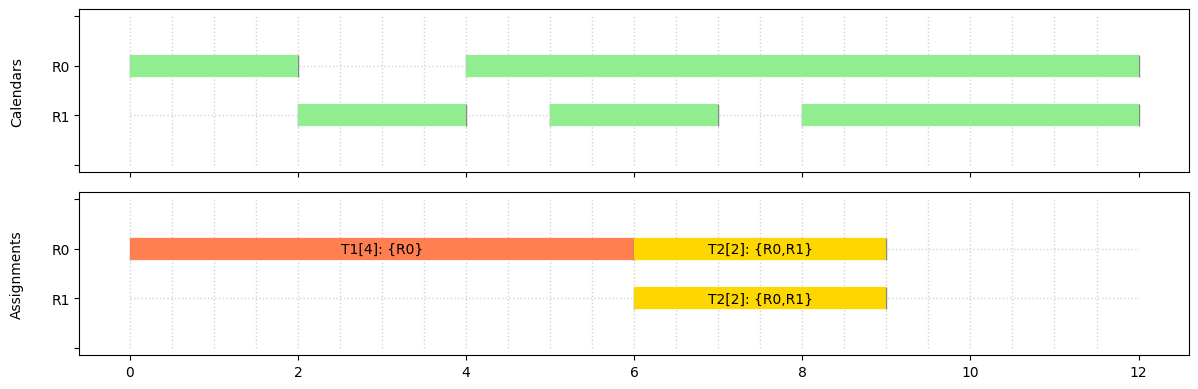

In [21]:
visualize_solution(sol, Mode_Intervals, RES_MAP, TASKS, M, origin=0, horizon=12)

## 4. Preemptive (With Delays) | Migration


INSTANCE: 4 Tasks × 2 Resources
Types: T1={R0,R1}

Task Dur Requirements              → Succ
---------------------------------------------------------------------------
T0   0   —                         [1, 2]
T1   4   1×T1                      [3]
T2   2   2×T1                      [3]
T3   0   —                         —

Res  Cap  Available Windows
---------------------------------------------------------------------------
R0   100  [0-2) [4-12)
R1   0    [2-4) [5-7) [8-12)

Solving Preemptive (With Delays) | Migration...

✓ SOLUTION - Makespan: 7
Task  Start End   Dur  Resources
---------------------------------------------------------------------------
T0    0     0     0    —
T1    0     4     4    {R0}
T2    4     7     3    {R0,R1}
T3    7     7     0    —



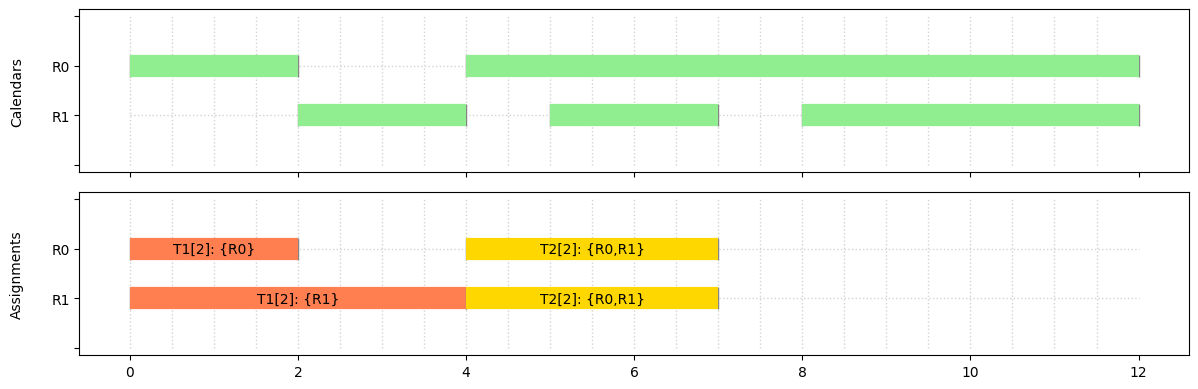

In [22]:
from docplex.cp.model import CpoModel, interval_var, end_of, end_before_start, span, no_overlap, minimize, size_of

N, M, TASKS, RESOURCES, PRECEDENCES = load_instance("../data/rcpspblocking/00.data")
RES_MAP = build_res_map(RESOURCES)
Task_Modes = build_task_modes(TASKS)

print_instance(N, M, TASKS, RESOURCES, PRECEDENCES)

mdl = CpoModel(name="preemptive_delays_migration_cpo")

# (7) G_{i,m}(t) = min(F_r(t)) - Joint intensity functions
Joint_Intensities = {
    (tid, mode): compute_joint_intensity(mode, RES_MAP)
    for tid in Task_Modes for mode in Task_Modes[tid]
}

# (8b) O_{i,m}: optional interval var with intensity G_{i,m}
# Note: No fixed size - work accumulates via intensity, total enforced by constraint (6)
Mode_Intervals = {
    (tid, mode): interval_var(intensity=Joint_Intensities[(tid, mode)],
                              optional=True, name=f"T{tid}_Mode_{mode}")
    for tid, size, _ in TASKS for mode in Task_Modes[tid]
}

# (8a) T_i: mandatory interval var (no fixed size - determined by span)
T = {tid: interval_var(name=f"T{tid}") for tid, _, _ in TASKS}

# Store task sizes for constraint (6)
Task_Sizes = {tid: size for tid, size, _ in TASKS}

# (1) Objective: minimize makespan
mdl.add(minimize(mdl.max([end_of(T[i]) for i in range(N)])))

# (2) Precedences: endBeforeStart(T_i, T_j)
mdl.add([end_before_start(T[p], T[s]) for p, s in PRECEDENCES])

# (3) Span: task spans its mode intervals (allows migration between modes)
for tid in T:
    mode_itvs = [itv for (t, m), itv in Mode_Intervals.items() if t == tid]
    if mode_itvs:
        mdl.add(span(T[tid], mode_itvs))

# (4) Resource capacity: noOverlap per resource
for r in range(M):
    intervals = [itv for (t, m), itv in Mode_Intervals.items() if r in m]
    if intervals:
        mdl.add(no_overlap(intervals))

# (6) Total work constraint: sum of sizes across modes equals task duration
for tid in T:
    mode_itvs = [itv for (t, m), itv in Mode_Intervals.items() if t == tid]
    if mode_itvs and Task_Sizes[tid] > 0:
        mdl.add(sum([size_of(itv, 0) for itv in mode_itvs]) == Task_Sizes[tid])

print("Solving Preemptive (With Delays) | Migration...")
sol = mdl.solve(LogVerbosity='Quiet')
print_solution(sol, T, Mode_Intervals, N)

visualize_solution(sol, Mode_Intervals, RES_MAP, TASKS, M, origin=0, horizon=12)

## 5. Multi-Resource Heterogeneous Policy